In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

pd.set_option("display.max_columns", 1000)

/home/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



In [2]:
# links
# https://drive.google.com/drive/folders/18dV790r11hHKIwpbyDBaxMV4XbhBFQde?usp=drive_link

In [3]:
# entsoe network file
# entsoe_nc = pypsa.Network("elec-entsoe.nc")

INFO:pypsa.io:Imported network elec-entsoe.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


In [4]:
entsoe_nc.lines.head()

,bus0,bus1,v_nom,num_parallel,length,underground,under_construction,tags,geometry,type,s_max_pu,s_nom,capital_cost,x,r,g,b,s_nom_extendable,s_nom_min,s_nom_max,build_year,lifetime,carrier,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8968,1771,1774,220,1.0,43.467839,False,False,,"LINESTRING(-6.96214005610054 38.9081662916356,...",Al/St 240/40 2-bundle 220.0,0.7,491.556019,2235.122095,0.0,0.0,0.0,0.0,False,0.0,inf,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9005,2774,2776,220,1.0,11.705938,False,False,,"LINESTRING(-1.00930817295372 41.3431267158445,...",Al/St 240/40 2-bundle 220.0,0.7,491.556019,601.920908,0.0,0.0,0.0,0.0,False,0.0,inf,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9316,3576,3577,220,1.0,10.765484,False,False,,"LINESTRING(7.05226243630703 47.8010466193602,7...",Al/St 240/40 2-bundle 220.0,0.7,491.556019,553.562611,0.0,0.0,0.0,0.0,False,0.0,inf,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11229,3792,3794,380,2.0,20.533361,False,False,,"LINESTRING(10.2047502877043 48.6231969454801,1...",Al/St 240/40 4-bundle 380.0,0.7,3396.205223,1055.828178,0.0,0.0,0.0,0.0,False,0.0,inf,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11228,3793,3794,380,2.0,14.408688,False,False,,"LINESTRING(10.1706712730649 48.4950605419181,1...",Al/St 240/40 4-bundle 380.0,0.7,3396.205223,740.896662,0.0,0.0,0.0,0.0,False,0.0,inf,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# networks
de_base_nc_file = "osm_data_validation_AT_MK_IT_DE/networks/DE/base.nc"
it_base_nc_file = "osm_data_validation_AT_MK_IT_DE/networks/IT/base.nc"

# resources
de_base_csv_file = "osm_data_validation_AT_MK_IT_DE/resources/DE/base_network/all_lines_build_network.csv"
it_base_csv_file = "osm_data_validation_AT_MK_IT_DE/resources/IT/base_network/all_lines_build_network.csv"

de_country_shape_file = "osm_data_validation_AT_MK_IT_DE/resources/DE/shapes/country_shapes.geojson"
it_country_shape_file = "osm_data_validation_AT_MK_IT_DE/resources/IT/shapes/country_shapes.geojson"

In [6]:
de_base_nc = pypsa.Network(de_base_nc_file)
it_base_nc = pypsa.Network(it_base_nc_file)

de_base_csv = pd.read_csv(de_base_csv_file)
it_base_csv = pd.read_csv(it_base_csv_file)

INFO:pypsa.io:Imported network base.nc has buses, lines, links, transformers
INFO:pypsa.io:Imported network base.nc has buses, lines, links, transformers


In [7]:
de_country_shape = gpd.read_file(de_country_shape_file)
it_country_shape = gpd.read_file(it_country_shape_file)

In [8]:
# load entsoe line.csv with pandas dataframe
entsoe_ref_csv = pd.read_csv("entsoe_lines_ref.csv", delimiter=",", quotechar="'")

# apply well known text(wkt) to format the geometry column properly
entsoe_ref_csv["geometry"] = entsoe_ref_csv.geometry.apply(wkt.loads)

# load the data into a geopandas dataframe and format it using a compatible crs
entsoe = gpd.GeoDataFrame(entsoe_ref_csv, geometry="geometry", crs="EPSG:3035")

# convert voltage from kV to V
entsoe["voltage"] = entsoe.voltage * 1000

In [9]:
def if_country_in_entsoe(country_df: gpd.GeoDataFrame, base_data: gpd.GeoDataFrame) -> pd.Series:
    """
    Function checks if country_df is present in enstoe data
    """
    x = base_data["geometry"].apply(lambda row: row.within(country_df["geometry"][0]))
    return x

def get_i_nom_by_voltage(voltage_value: int) -> int:

    voltage_dict = {
        "220" : 1.29, # "Al/St 240/40 2-bundle 220.0"
        "300" : 1.935, # "Al/St 240/40 3-bundle 300.0,"
        "380" : 2.58 # "Al/St 240/40 4-bundle 380.0"
    }

    if voltage_value <= 220000:
        current = voltage_dict["220"]
    # elif voltage_value >= 220000 and voltage_value <= 300000:
    #     current = voltage_dict["300"]
    elif voltage_value > 220000:
        current = voltage_dict["380"]

    return current # units in kA

def calculate_s_nom(df: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # s_nom = sqrt(3) * v_nom(V) * i_nom(MA)
    # divide voltage by 1e3 to convert it to kV
    
    df["i_nom"] = df["voltage"].apply(get_i_nom_by_voltage)
    df["s_nom"] = df["voltage"].apply(lambda row: (row / 1e3) * np.sqrt(3) * get_i_nom_by_voltage(row))
    # s_nom units in ???

    return df
    

In [10]:
de_base_csv.shape

(4875, 21)

In [11]:
de_base_nc.lines.shape

(4861, 45)

In [12]:
de_base_csv_s_nom = calculate_s_nom(de_base_csv)
it_base_csv_s_nom = calculate_s_nom(it_base_csv)

In [13]:
de_base_csv_s_nom.i_nom.value_counts()

1.29    4205
2.58     670
Name: i_nom, dtype: int64

In [14]:
de_base_nc.lines.type.map(de_base_nc.line_types.i_nom).value_counts()

1.29    4205
2.58     656
Name: type, dtype: int64

In [15]:
entsoe["if_de"] = if_country_in_entsoe(de_country_shape, entsoe)
entsoe["if_it"] = if_country_in_entsoe(it_country_shape, entsoe)

In [16]:
# https://github.com/pypsa-meets-earth/pypsa-earth/blob/2482704c0c413a625107f4c68c41e4f9481e0b08/scripts/base_network.py#L353
de_base_nc_s_som_sum = (de_base_nc.lines.s_nom / de_base_nc.lines.num_parallel).sum() # removing the effect of num_parallel
de_base_nc_s_som_sum

3180948.3739875257

In [17]:
de_base_csv_s_som_sum = de_base_csv_s_nom.s_nom.sum()
de_base_csv_s_som_sum

2269744.278182016

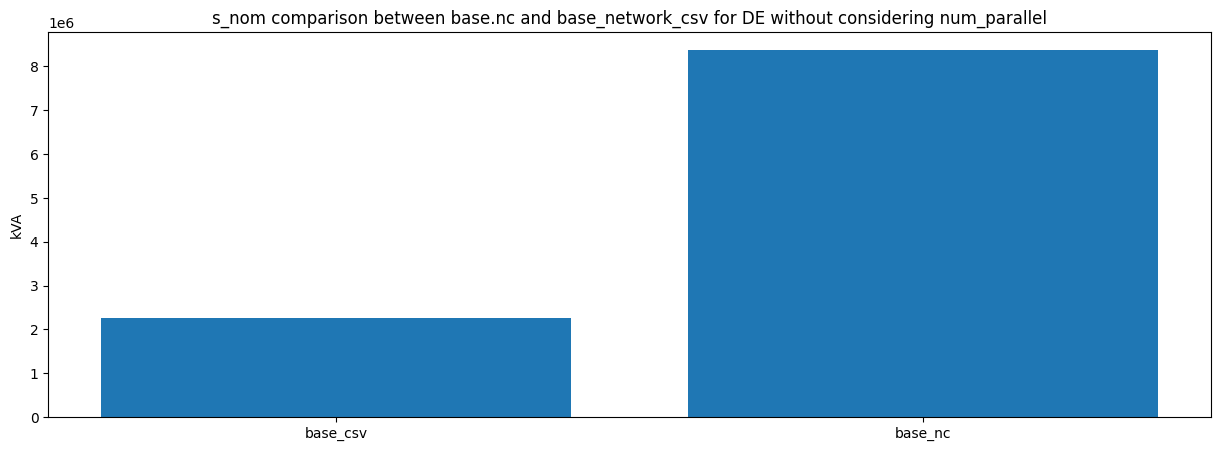

In [18]:
plt.figure(figsize=(15,5))
plt.bar(["base_csv", "base_nc"], [de_base_csv_s_som_sum, de_base_nc.lines.s_nom.sum()])
plt.title("s_nom comparison between base.nc and base_network_csv for DE without considering num_parallel")
plt.ylabel("kVA")
plt.show()

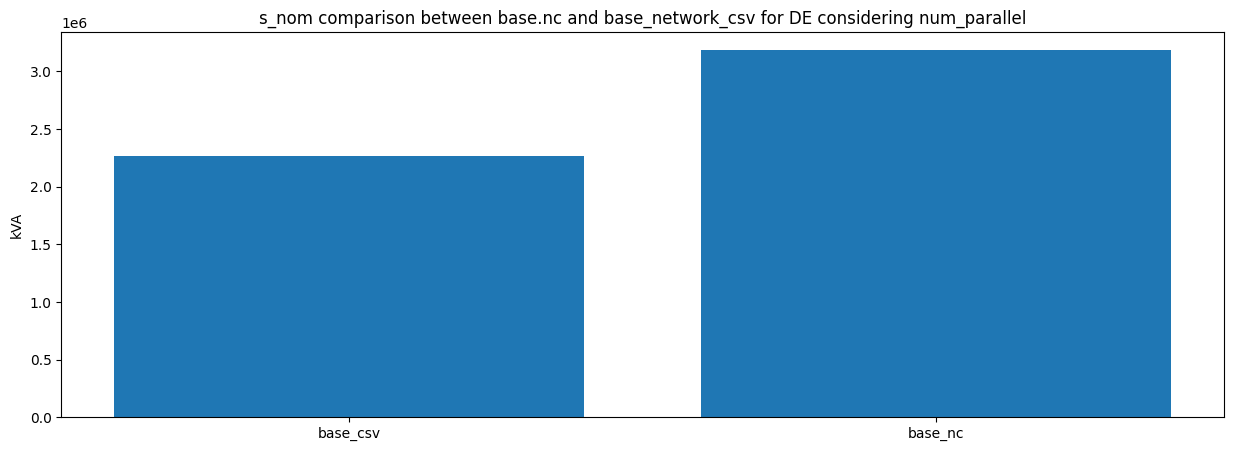

In [19]:
plt.figure(figsize=(15,5))
plt.bar(["base_csv", "base_nc"], [de_base_csv_s_som_sum, de_base_nc_s_som_sum])
plt.title("s_nom comparison between base.nc and base_network_csv for DE considering num_parallel")
plt.ylabel("kVA")
plt.show()

In [20]:
de_nc_s_nom_sum = (de_base_nc.lines.s_nom * de_base_nc.lines.length).sum()
de_nc_s_nom_sum

153343515.04116735

In [21]:
de_base_nc.lines.type.map(de_base_nc.line_types.i_nom).value_counts()

1.29    4205
2.58     656
Name: type, dtype: int64

In [22]:
de_base_nc.lines.v_nom.value_counts()

220.0    4205
380.0     656
Name: v_nom, dtype: int64

In [23]:
de_base_s_nom_sum = (de_base_csv_s_nom.s_nom * (de_base_csv_s_nom.length / 1000)).sum() #units in MVA
de_base_s_nom_sum

50519885.79186985

### Length Comparison

In [24]:
de_base_len = de_base_csv_s_nom[de_base_csv_s_nom.voltage >= 220000].length.sum() / 1000
de_base_len

29737.03489177709

In [25]:
de_nc_len = de_base_nc.lines.length.sum()
de_nc_len

81216.86740594925

<BarContainer object of 2 artists>

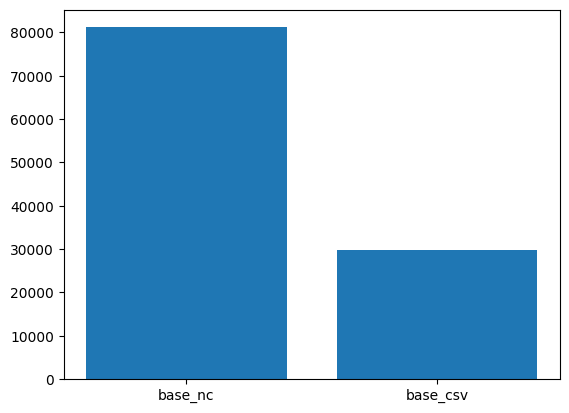

In [26]:
plt.bar(["base_nc", "base_csv"], [de_nc_len, de_base_len])

In [27]:
it_base_len = it_base_csv_s_nom[it_base_csv_s_nom.voltage >= 220000].length.sum() / 1000
it_base_len

25900.686384993845

In [28]:
it_nc_len = it_base_nc.lines.length.sum()
it_nc_len

76733.79762755937

<BarContainer object of 2 artists>

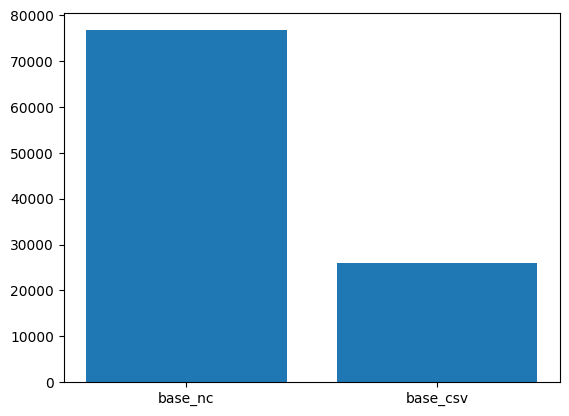

In [29]:
plt.bar(["base_nc", "base_csv"], [it_nc_len, it_base_len])